# Mock mass-calibration con Ragagnin2020 o Diemer2019

## import e costanti

In [1]:
import hydro_mc, matplotlib.pyplot as plt, numpy as np, pint
from colossus.cosmology import cosmology
from colossus.halo import concentration

A_NFW = lambda c: (np.log(1.+c)-c/(1.+c))

ureg = pint.UnitRegistry()
ureg.define('Msun = 1.989e+30*kg')
ureg.define('kpc = 1e3*pc')
h0_units =  ureg.km/ureg.s/ureg.Mpc
G = 6.67408e-11*ureg.m**3/ureg.kg/ureg.s**2

##  funzioni per NFW 2D

In [2]:

def get_rho_crit_in_Msun_kpc3(h0):
    return (3*(100.*h0*h0_units)**2/(8*np.pi*G)).to('Msun/kpc^3').magnitude

def get_R_kpc(delta, a, omega_m, h0, M):
    critical_overdensity = hydro_mc.critical_overdensity(delta, a=a, omega_m = omega_m)
    rho_crit_Msun_kpc3 = get_rho_crit_in_Msun_kpc3(h0)
    r_3 = M/(critical_overdensity*4./3.*np.pi*rho_crit_Msun_kpc3)
    r = r_3**(1/3)
    #print('r',r)
    return r 

A_NFW = hydro_mc.f_NFW
sqrt = np.sqrt
log = np.log

def nfw2_return_from_rho0_rs(rho0, rs, radii):
    # si veda Lokas & Mamon 2001 ( https://ui.adsabs.harvard.edu/abs/2001MNRAS.321..155L/abstract )
    a=rs
    b=radii
    v1= -2*rho0*rs*((a**2 *  (a**2-b**2+a * sqrt(-a**2 + b**2)* np.arccos(a/b))/(a**2-b**2)**2))
    v2 = 2*rho0*a**3 * (1./(-a**2+b**2)+(a * np.arccosh(a/b))/(a**2-b**2)**(1.5))
    # we check if radii is scalar or array
    if hasattr(radii, "__getitem__") and not np.array(radii).shape==(): 
        mask = np.isnan(v1)
        v1[mask] = v2[mask]
        return v1
    else:
        return v1 if np.isnan(v2) else v2

def nfw2_profile_from_M_c(M,c, delta, a, omega_m, h0,radii):
    #print('M',M_1e10Msun, M)
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    a=rs
    #print('rho0', rho0, 'rs', rs, 'r',r)
    return nfw2_return_from_rho0_rs(rho0, rs, radii)

##  funzioni per mass calibration


In [3]:
from scipy import optimize
def nfw2_profile_from_M200c_Ragagnin2020(M, a, delta, omega_m, omega_b, sigma8, h0,radii):
    Rhalo = get_R_kpc('200c', a, omega_m, h0, M)
    c = hydro_mc.concentration_from_mc_relation(delta, M=M, a=a, omega_m = omega_m, omega_b = omega_b, sigma8=sigma8, h0=h0)
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)

def nfw2_profile_from_M200c_Diemer2019(M, a, delta, omega_m, omega_b, sigma8, h0,radii):

    _params = {'flat': True, 
               'H0': h0*100., 
               'Om0': omega_m, 
               'Ob0': omega_b,
               'sigma8': sigma8,
              'ns':.963}
    Rhalo = get_R_kpc(delta, a, omega_m, h0, M)
    cosmology.setCosmology('myCosmo', _params)
    if M>1e16:
        return np.nan
    #diemer vuole masse/h
    c = concentration.modelDiemer19(M/h0, 1./a-1.)[0]
    rs = Rhalo/c
    rho0 = M/(4./3.*np.pi*rs**3)*1/(3*A_NFW(c))
    return nfw2_return_from_rho0_rs(rho0, rs, radii)


def calibra_massa_su_profilo(rho, log_rho_err, funzione_profilo_M_radii):
       
    errorfunc = lambda logM: (np.log(funzione_profilo_M_radii(np.exp(logM))) - np.log(rho))/log_rho_err  
    
    p1, success = optimize.leastsq( errorfunc, x0 = 14.)
    if not success:
        print(p1, success)
        raise Exception('ahi ahi toppai!')
    return np.exp(p1)

def calibra_massa_Ragagnin2020(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    return calibra_massa_su_profilo(
       rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Ragagnin2020(M, a, delta, omega_m, omega_b, sigma8, h0,radii)
    )

def calibra_massa_Diemer2019(radii, rho, log_rho_err, a, delta, omega_m, omega_b, sigma8, h0):
    return calibra_massa_su_profilo(
      rho, log_rho_err,
        lambda M: nfw2_profile_from_M200c_Diemer2019(M, a,  delta, omega_m, omega_b, sigma8, h0,radii)
    )

## funzioni per creare mock data con SN=5

/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


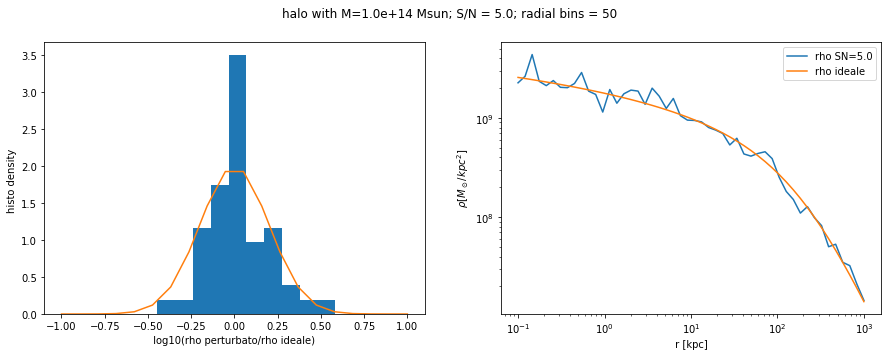

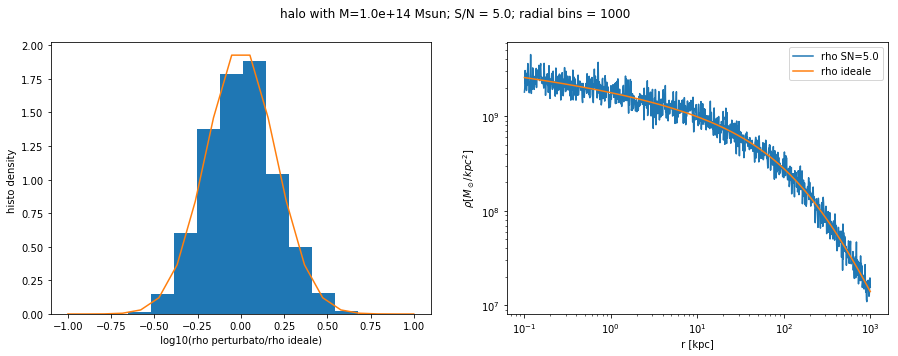

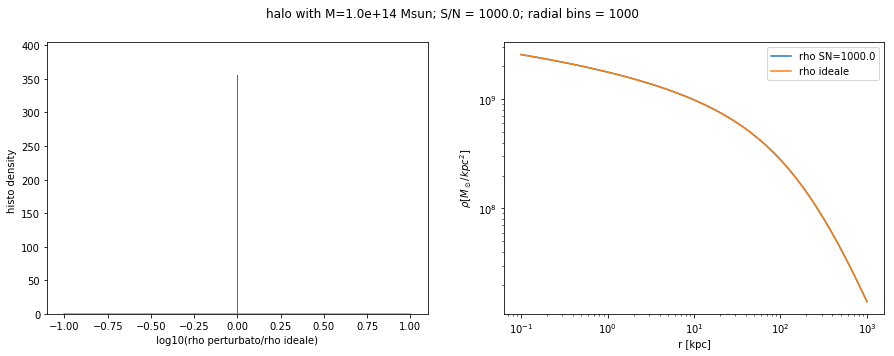

In [4]:
import scipy.stats as stats

def genera_profilo_con_SN(M, c,  a, delta, omega_m, omega_b, sigma8, h0, sn, radii_n=50, plotta=False):

    radii = np.logspace(-1, 3, radii_n)
    rho_ideale = nfw2_profile_from_M_c(M, c, delta, a, omega_m,   h0, radii)
    rho_perturbato = rho_ideale * np.exp(np.random.normal(loc=0, scale=1./sn, size =  radii_n))
    rho_perturato_errore = rho_perturbato*1./sn
    if plotta:
        f, axes = plt.subplots(1,2, figsize=(15,5))
        ax = axes[0]
        ax.hist(np.log(rho_perturbato/rho_ideale), density=True)
        xs = np.linspace(-1,1,20)
        ax.plot(xs, stats.norm.pdf(xs, 0., 1./sn))
        ax.set_xlabel(' log10(rho perturbato/rho ideale) ')
        ax.set_ylabel('histo density ')
        
        ax = axes[1]        
        ax.plot(radii,rho_perturbato, label = 'rho SN=%.1f'%sn )
        ax.plot(radii,rho_ideale, label = 'rho ideale' )
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(' r [kpc] ')
        ax.set_ylabel(r' $\rho [M_\odot/kpc^2]$ ')
        ax.legend()
        f.suptitle('halo with M=%.1e Msun; S/N = %.1f; radial bins = %d'%(M, sn, radii_n))
    return radii, rho_ideale, rho_perturbato, rho_perturato_errore


# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(M=1.e14, c=4., a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 5., radii_n=50, plotta=True);

# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(1.e14, c=4.,  a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 5., radii_n=1000, plotta=True);


# testo che il profilo abbia veramente SN=5 (cioe coincida con gaussiana con sigma = .25)
genera_profilo_con_SN(1.e14, c=4.,  a=0.4, delta='200c', omega_m=0.3, omega_b=0.04, sigma8=0.8, h0=0.7, sn = 1000., radii_n=1000, plotta=True);


In [5]:
def confronta(M = 1.428571e14, sn=None, outputta=False, plotta=False, fig=None, ax=None, delta='200c', params =  None):
    # in teoria anche la cosmologia potrebbe essere sconosciuta
    omega_m = 0.27
    omega_b = 0.004
    sigma8 = 0.8
    h0=1.
    a = 1.
        
    # da una M e una c della mia Mc, genero un profilo disturbato
    
    c = hydro_mc.concentration_from_mc_relation(delta, M=    M, a=a, omega_m = omega_m, 
                                                omega_b =omega_b, 
                                                sigma8=sigma8,  h0=h0)
    
    # scommentare se si vuole provare lo stesso esperimento calibrando un profilo generato con Mc di Diemer
    #c =  concentration.modelDiemer15fromM(M/h0, 1./a-1.) #diemer Vuole M/h
    radii, prof2d_ideal, prof2d_niosy, prof2d_niosy_error = genera_profilo_con_SN(M, c,  a=a, delta=delta, omega_m=omega_m, omega_b=omega_b,
                                                                    sigma8=sigma8, h0=h0, sn = sn,radii_n=50, 
                                                                    plotta=False)
    
    # ora provo a recuperarlo usando Ragag2020 o Diemer2016
    
    prof2d_res1 = calibra_massa_Ragagnin2020(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    prof2d_M1  = prof2d_res1 #.x #prendo risultato di scipy.leastsq
    prof2d_c1 = hydro_mc.concentration_from_mc_relation(delta, M=   prof2d_M1,
                                            a=a, omega_m = omega_m, 
                                            omega_b =omega_b, 
                                            sigma8=sigma8, 
                                            h0=h0)
    
    prof2d_res2 = calibra_massa_Diemer2019(radii, prof2d_niosy, np.log(prof2d_niosy_error) , a, delta, omega_m, omega_b, sigma8, h0)
    prof2d_M2  = prof2d_res2 #.x #prendo risultato di scipy.leastsq
    prof2d_c2 =  concentration.modelDiemer19(prof2d_M2/h0, 1./a-1.)[0] #diemer Vuole M/h
    #print(prof2d_M2, prof2d_c2)
    #ora plotto in caso
    if plotta:
        ax.plot(radii*1.1, prof2d_ideal, label='ideal profile')
        #ax.plot(radii, nfw2_profile_from_M_c_prova(Mvir/ureg.Msun/1e10, c_vir, delta, params['a'], params['omega_m'], params['h0'], radii), label='idel profile 2' )
        ax.plot(radii*.9, prof2d_niosy, label='profile with S/N=5')
        ax.plot(radii, nfw2_profile_from_M_c(prof2d_M1,prof2d_c1, delta, a, omega_m, h0, radii), label='mass recovered with Ragagnin+2020' )
        ax.plot(radii, nfw2_profile_from_M_c(prof2d_M2,prof2d_c2, delta, a, omega_m, h0, radii), label='mass recovered with Diemer+2016' )
    if outputta:
        print('Ragagnin Recovered mass %e: Msun and concentration: %.2f'%(
            prof2d_M1,prof2d_c1))
        print('Dimer Recovered mass %e: Msun and concentration: %.2f'%(
            prof2d_M2,prof2d_c2))
        print('Original mass %e: Msun and concentration: %.2f'%(
            M,c))
    return prof2d_M1,prof2d_M2

/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


Ragagnin Recovered mass 1.459334e+14: Msun and concentration: 6.73
Dimer Recovered mass 1.732531e+14: Msun and concentration: 4.38
Original mass 1.420000e+14: Msun and concentration: 6.79



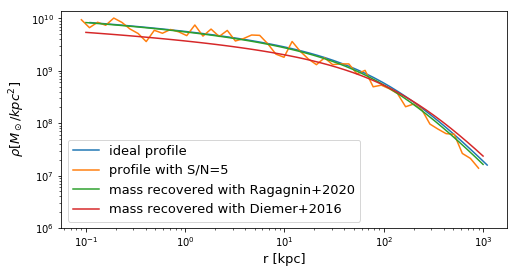

In [6]:
#print('NO NOISE')
#fig,ax = plt.subplots(1)
#confronta(radii, params=params, plotta=True, fig=fig, ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#print()
#print('\nS/N = 5.')


fig,ax = plt.subplots(1,figsize=(8,4))
confronta(M = 1.42e14, sn=5.,  plotta=True, fig=fig, ax=ax, outputta=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e6,None])
ax.legend(fontsize=13)
ax.set_xlabel('r [kpc]',fontsize=13)
ax.set_ylabel(r'$\rho [M_\odot/kpc^2]$',fontsize=13)
print()


S/N = 5.


/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arccos
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccosh
/home/moon/ragagnin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


ragagnin/dimer: 0.847
ragagnin/orig: 1.556
diemer/orig: 1.838
orig/orig: 0.546



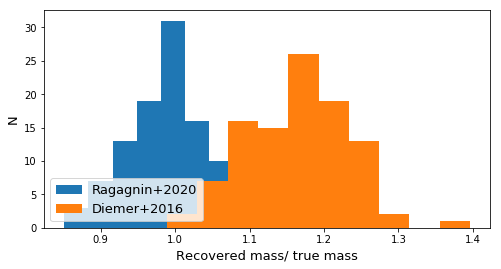

In [7]:
def confronta_n(n, sn=None, plotta=False):
    i=-1
    M1s =[]
    M2s =[]
    _n=0.
    while True:
        i+=1
        try:
            _M1, _M2 =  confronta(M = 1.42e14, sn=sn)
            M1s.append(_M1)
            M2s.append(_M2)
            _n+=1
        except Exception as e:
            print(e)
            pass
        if _n>n or i>10000:
            break
    #print(M1s)
    ra1 = np.array([x  for x in M1s])
    ra2 = np.array([x  for x in M2s])
    ra = ra1/ra2
    print('ragagnin/dimer: %.3f'%(np.mean(ra)))
    print('ragagnin/orig: %.3f'%(np.mean(np.array(ra1/9e13))))
    print('diemer/orig: %.3f'%(np.mean(np.array(ra2/9e13))))
    print('orig/orig: %.3f'%(np.mean(np.array(9e13/ra2))))
    if plotta:
        fig,ax = plt.subplots(1,figsize=(8,4))
        ax.hist(ra1/1.42e14,label = 'Ragagnin+2020')
        ax.hist(ra2/1.42e14,label = 'Diemer+2016')
        #ax.axvline(9e13, label='Original Mass',color='black' )
        ax.legend(fontsize=13,loc=3)
        ax.set_xlabel('Recovered mass/ true mass',fontsize=13)
        ax.set_ylabel('N',fontsize=13)
        #ax.set_xscale('log')
print('\nS/N = 5.')
confronta_n(100, sn=5., plotta=True)
print()




## test su libreria colossus

In [9]:
h0 = .6
_params = {'flat': True, 
               'H0': h0*100, 
               'Om0': .3, 
               'Ob0': 0.0491,
               'sigma8': 0.834,
              'ns':.9624}
a  = 1.
M = 1.7e14
M_su_h = M*h0
print('M = %.1eMsun = %.1eMsun/h; c=%.1f'%(M, M_su_h,concentration.modelDiemer19(M_su_h, 1./a-1.)[0]))

M = 1.7e+14Msun = 1.0e+14Msun/h; c=4.7
